In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pckgs.analyze import rocPlot, erorrMatrixPlot
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                           accuracy_score, confusion_matrix, roc_curve, average_precision_score)
from sklearn.calibration import CalibratedClassifierCV
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
N_FOLDS = 5
SCORING = 'roc_auc'


optuna.logging.set_verbosity(optuna.logging.WARNING) 

def randForestOpt(trial):
    """функция для оптимизации RandomForest"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': True,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }
    
    model = RandomForestClassifier(**params, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
    
    # Используем кросс-валидацию
    cv_scores = cross_val_score(
        model, 
        X_train_bal,
        y_train_bal,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='roc_auc',
        n_jobs=-1
    )
    
    return cv_scores.mean()


def gradOpt(trial):
    """функция для оптимизации GradientBoosting"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
    }
    
    model = GradientBoostingClassifier(**params, random_state=RANDOM_STATE)
    
    cv_scores = cross_val_score(
        model, 
        X_train_bal,
        y_train_bal,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='roc_auc',
        n_jobs=-1
    )
    
    return cv_scores.mean()


### Выбор данных для обучения

Используйте что-то из этого для обучения на сбалансированных или не сбалансированных данных  
**type_data = 'unbalanced'**  
**type_data = 'balanced'**
**type_data = 'balanced_medium'**

In [2]:
type_data = 'balanced_medium'
X_train_bal = pd.read_csv(f"../data/processed/train_{type_data}.csv").drop('Churn', axis=1)
y_train_bal = pd.read_csv(f"../data/processed/train_{type_data}.csv")['Churn']

In [3]:

X_test = pd.read_csv('../data/processed/test.csv').drop('Churn', axis=1)
y_test = pd.read_csv('../data/processed/test.csv')['Churn']

print(f"Размеры данных:")
print(f"  Обучающая (сбалансированная): {X_train_bal.shape}")
print(f"  Тестовая: {X_test.shape}")

# Разделяем на train/val для калибровки
X_train, X_val, y_train, y_val = train_test_split(
    X_train_bal, y_train_bal, 
    test_size=0.2, 
    stratify=y_train_bal,
    random_state=42
)

print(f"  Train для обучения: {X_train.shape}")
print(f"  Val для калибровки: {X_val.shape}")

# Стратифицированная K-fold стратегия
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Динамический подбор параметров
print("Подбор параметров для Рандом")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(randForestOpt, n_trials=50, show_progress_bar=True)
forest_params = study_rf.best_params
print(f"Лучшие параметры RandomForest: {forest_params}")


print("Подбор параметров для Градиент")
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(gradOpt, n_trials=50, show_progress_bar=True)
grad_params = study_gb.best_params
print(f"Лучшие параметры GradientBoosting: {grad_params}")


models = {
    'Random Forest': RandomForestClassifier(
        **forest_params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(**grad_params, random_state=RANDOM_STATE)
}



Размеры данных:
  Обучающая (сбалансированная): (7021, 34)
  Тестовая: (1407, 34)
  Train для обучения: (5616, 34)
  Val для калибровки: (1405, 34)
Подбор параметров для Рандом


  0%|          | 0/50 [00:00<?, ?it/s]

Лучшие параметры RandomForest: {'n_estimators': 302, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}
Подбор параметров для Градиент


  0%|          | 0/50 [00:00<?, ?it/s]

Лучшие параметры GradientBoosting: {'n_estimators': 358, 'learning_rate': 0.03515009170246084, 'max_depth': 7, 'min_samples_split': 43, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'subsample': 0.7745242528697025}


### Обучение моделей с лучшими параметрами


 RANDOM FOREST
----------------------------------------
Кросс-валидация (5-fold stratified)
   ROC-AUC на каждом фолде: [0.89579596 0.87949806 0.89231989 0.89946756 0.90239156]
   Средний ROC-AUC: 0.894 ± 0.008


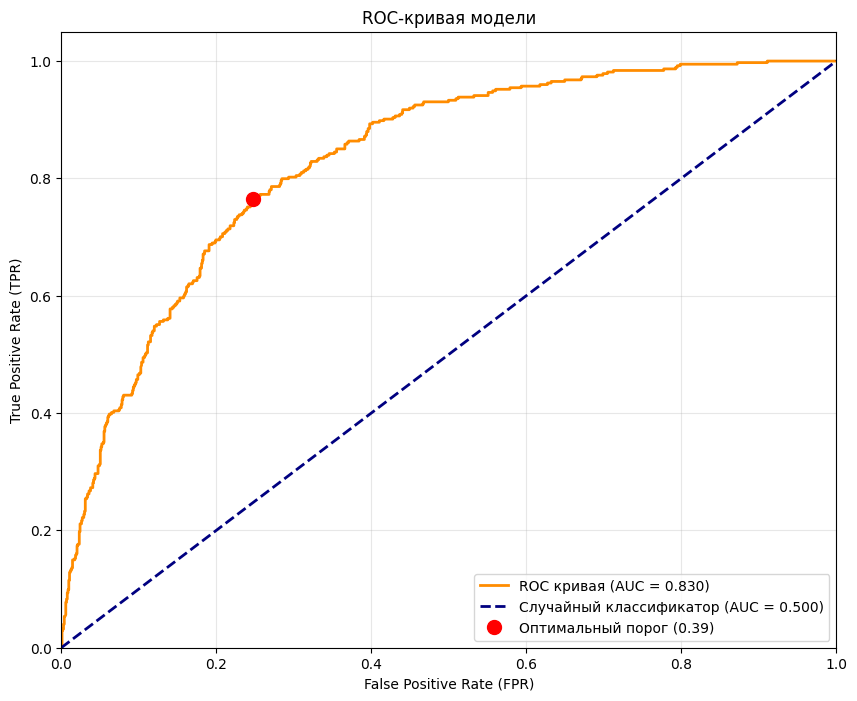

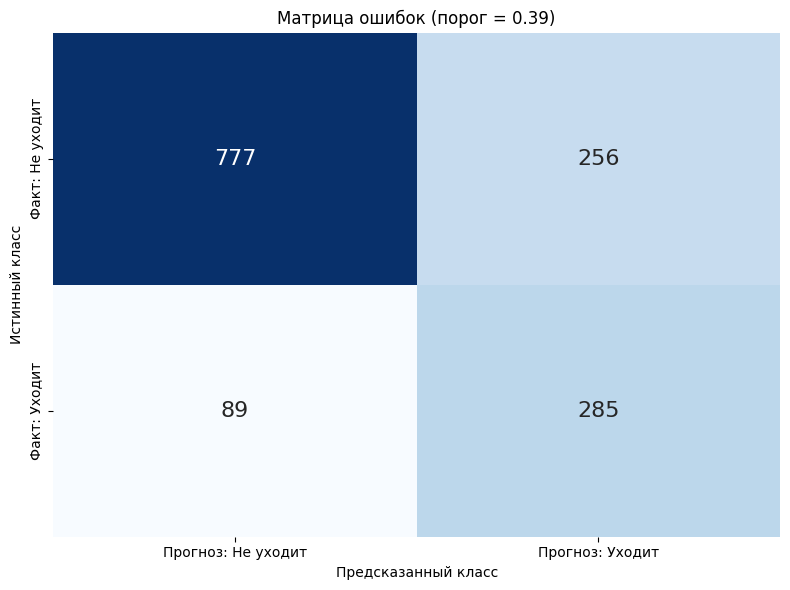

Метрики на тесте:
   ROC-AUC:     0.830
   PR-AUC:      0.620
   F1-Score:    0.599
   Precision:   0.564
   Recall:      0.639
   Accuracy:    0.773

 GRADIENT BOOSTING
----------------------------------------
Кросс-валидация (5-fold stratified)
   ROC-AUC на каждом фолде: [0.91113091 0.90001738 0.90450811 0.91321833 0.91340055]
   Средний ROC-AUC: 0.908 ± 0.005


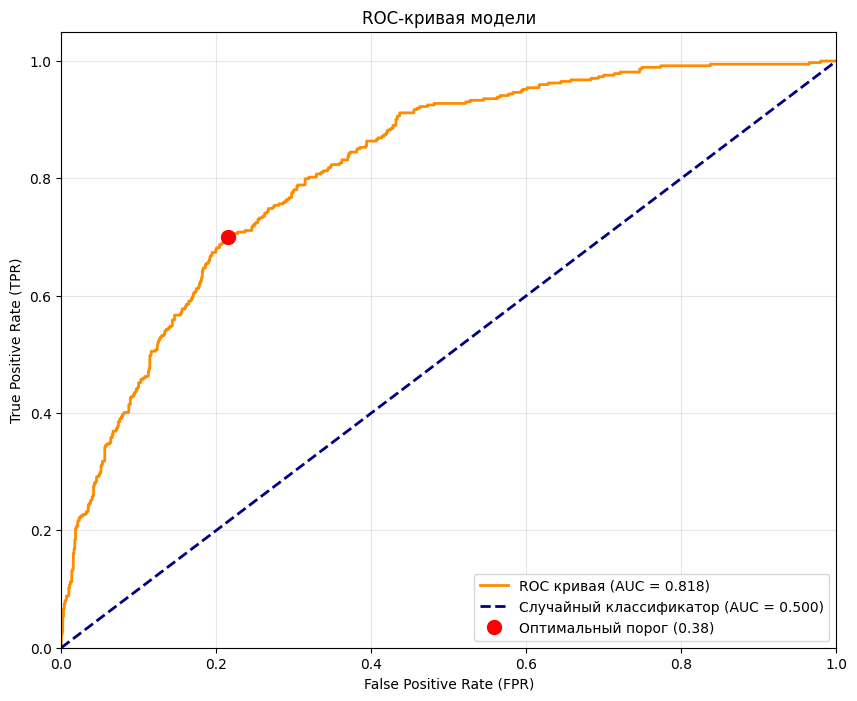

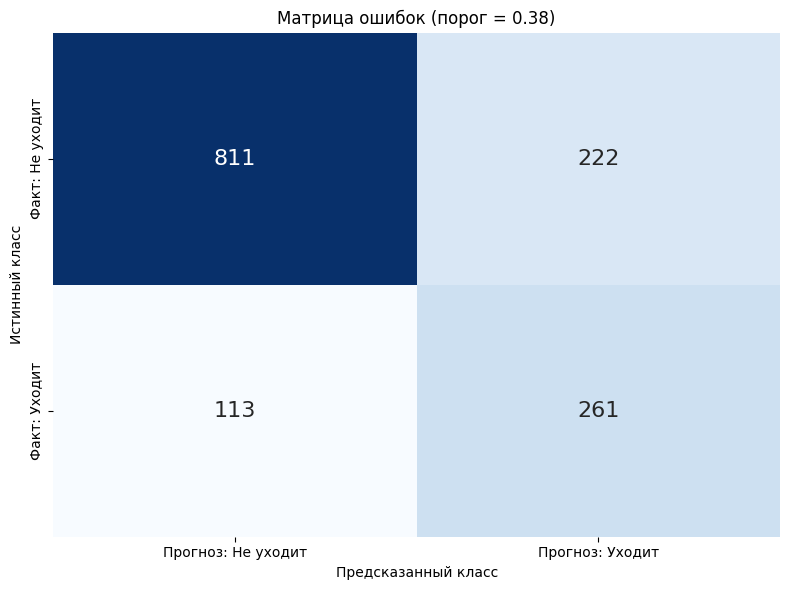

Метрики на тесте:
   ROC-AUC:     0.818
   PR-AUC:      0.613
   F1-Score:    0.578
   Precision:   0.565
   Recall:      0.591
   Accuracy:    0.770


In [4]:
results = []

for model_name, model in models.items():
    print(f"\n {model_name.upper()}")
    print("-" * 40)
    
    
    print("Кросс-валидация (5-fold stratified)")
    cv_scores = cross_val_score(
        model, X_train_bal, y_train_bal,
        cv=skf,
        scoring=SCORING,
        n_jobs=-1
    )
    print(f"   ROC-AUC на каждом фолде: {cv_scores}")
    print(f"   Средний ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'model': model_name,
        'cv_roc_auc_mean': cv_scores.mean(),
        'cv_roc_auc_std': cv_scores.std(),
        'test_roc_auc': roc_auc_score(y_test, y_proba),
        'test_pr_auc': average_precision_score(y_test, y_proba),
        'test_f1': f1_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_accuracy': accuracy_score(y_test, y_pred)
    }
    
    results.append(metrics)

    postfix = model_name.lower().replace(' ', '_')
    rocPlot(y_test, y_proba, f"{type_data}_{postfix}")
    erorrMatrixPlot(y_test, y_proba, f"{type_data}_{postfix}")
    
    print(f"Метрики на тесте:")
    print(f"   ROC-AUC:     {metrics['test_roc_auc']:.3f}")
    print(f"   PR-AUC:      {metrics['test_pr_auc']:.3f}")
    print(f"   F1-Score:    {metrics['test_f1']:.3f}")
    print(f"   Precision:   {metrics['test_precision']:.3f}")
    print(f"   Recall:      {metrics['test_recall']:.3f}")
    print(f"   Accuracy:    {metrics['test_accuracy']:.3f}")
    



### Выбор лучшей модели и Калибровка

In [5]:

results_df = pd.DataFrame(results)
best_model_info = results_df.loc[results_df['test_roc_auc'].idxmax()]
best_model_name = best_model_info['model']

print(f"Лучшая модель по ROC-AUC: {best_model_name}")
print(f"   ROC-AUC на тесте: {best_model_info['test_roc_auc']:.3f}")
print(f"   ROC-AUC на кросс-валидации: {best_model_info['cv_roc_auc_mean']:.3f}")

# Калибровка модели
print(f"\nКАЛИБРОВКА МОДЕЛИ {best_model_name}")

# Получаем лучшую модель
if best_model_name == 'Random Forest':
    base_model = RandomForestClassifier(
        **forest_params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
else:
    base_model = GradientBoostingClassifier(
        **grad_params,
        random_state=RANDOM_STATE
    )

# Обучаем базовую модель
base_model.fit(X_train, y_train)

# Platt scaling (SIGMOID CALIBRATION)
calibrated_model = CalibratedClassifierCV(
    base_model,
    method='sigmoid',
    cv='prefit'
)
calibrated_model.fit(X_val, y_val)

# Изотоническая регрессия
isotonic_model = CalibratedClassifierCV(
    base_model,
    method='isotonic',
    cv='prefit'
)
isotonic_model.fit(X_val, y_val)

# Оценка калибровки
print("\n Оценка калибровки на тесте:")

# Предсказания разных моделей
y_proba_base = base_model.predict_proba(X_test)[:, 1]
y_proba_sigmoid = calibrated_model.predict_proba(X_test)[:, 1]
y_proba_isotonic = isotonic_model.predict_proba(X_test)[:, 1]

calibration_results = pd.DataFrame({
    'Model': ['Без калибровки', 'Platt scaling', 'Isotonic regression'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_base),
        roc_auc_score(y_test, y_proba_sigmoid),
        roc_auc_score(y_test, y_proba_isotonic)
    ],
    'PR-AUC': [
        average_precision_score(y_test, y_proba_base),
        average_precision_score(y_test, y_proba_sigmoid),
        average_precision_score(y_test, y_proba_isotonic)
    ],
    'Brier Score': [
        np.mean((y_proba_base - y_test) ** 2),
        np.mean((y_proba_sigmoid - y_test) ** 2),
        np.mean((y_proba_isotonic - y_test) ** 2)
    ]
})

print(calibration_results.to_string(index=False))


Лучшая модель по ROC-AUC: Random Forest
   ROC-AUC на тесте: 0.830
   ROC-AUC на кросс-валидации: 0.894

КАЛИБРОВКА МОДЕЛИ Random Forest

 Оценка калибровки на тесте:
              Model  ROC-AUC   PR-AUC  Brier Score
     Без калибровки 0.829743 0.620254     0.149020
      Platt scaling 0.829743 0.620254     0.153954
Isotonic regression 0.829003 0.605673     0.154324



 Финальная модель: Random Forest с Без калибровки
   ROC-AUC: 0.830


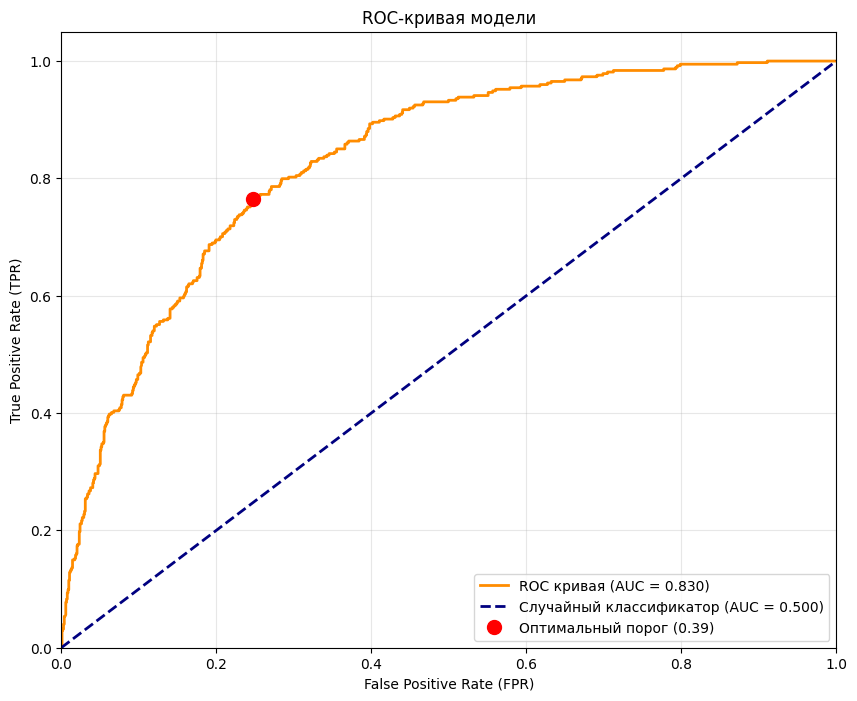

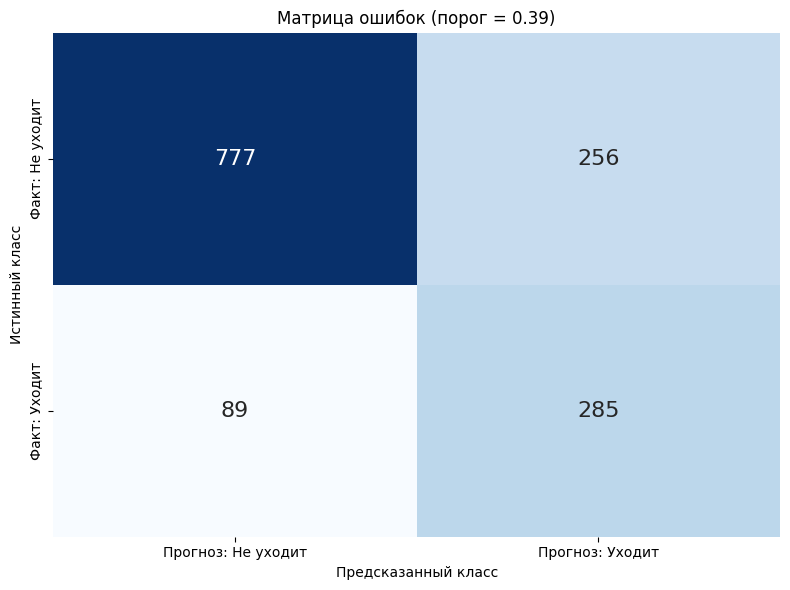


 ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
-----------------------------------------------------------
Лучшая модель: Random Forest с Без калибровки
ROC-AUC: 0.830 
F1-Score: 0.599
Precision: 0.564 (точность предсказаний оттока)
Recall: 0.639 (находим 63.9% ушедших)



In [6]:

# Выбираем лучший калиброванный вариант
best_calibrated_idx = calibration_results['ROC-AUC'].idxmax()
best_calibrated_model_name = calibration_results.loc[best_calibrated_idx, 'Model']

if best_calibrated_model_name == 'Platt scaling':
    final_model = calibrated_model
elif best_calibrated_model_name == 'Isotonic regression':
    final_model = isotonic_model
else:
    final_model = base_model

print(f"\n Финальная модель: {best_model_name} с {best_calibrated_model_name}")
print(f"   ROC-AUC: {calibration_results.loc[best_calibrated_idx, 'ROC-AUC']:.3f}")

y_proba_final = final_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_proba_final > 0.5).astype(int)

postfix = model_name.lower().replace(' ', '_')
rocPlot(y_test, y_proba_final, f"{type_data}_final_model_{postfix}")
erorrMatrixPlot(y_test, y_proba_final, f"{type_data}_final_model_{postfix}")

final_metrics = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_final),
    'PR-AUC': average_precision_score(y_test, y_proba_final),
    'Accuracy': accuracy_score(y_test, y_pred_final),
    'F1-Score': f1_score(y_test, y_pred_final),
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final)
}

result_models = pd.DataFrame(columns=['model', 'ROC-AUC', 'PR-AUC', 'Accuracy', 'F1-Score', 'Precision', 'Recall'])
result_models.loc[len(result_models)] = {
    'model': 'final model',
    **final_metrics
}


joblib.dump(final_model, f"../models/final_model_{type_data}.pkl") 

# Итоговый отчёт
print(f"""
 ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
-----------------------------------------------------------
Лучшая модель: {best_model_name} с {best_calibrated_model_name}
ROC-AUC: {final_metrics['ROC-AUC']:.3f} 
F1-Score: {final_metrics['F1-Score']:.3f}
Precision: {final_metrics['Precision']:.3f} (точность предсказаний оттока)
Recall: {final_metrics['Recall']:.3f} (находим {final_metrics['Recall']:.1%} ушедших)
""")

### Ансамбли

Обучение ансамбля Forest + Boosting...


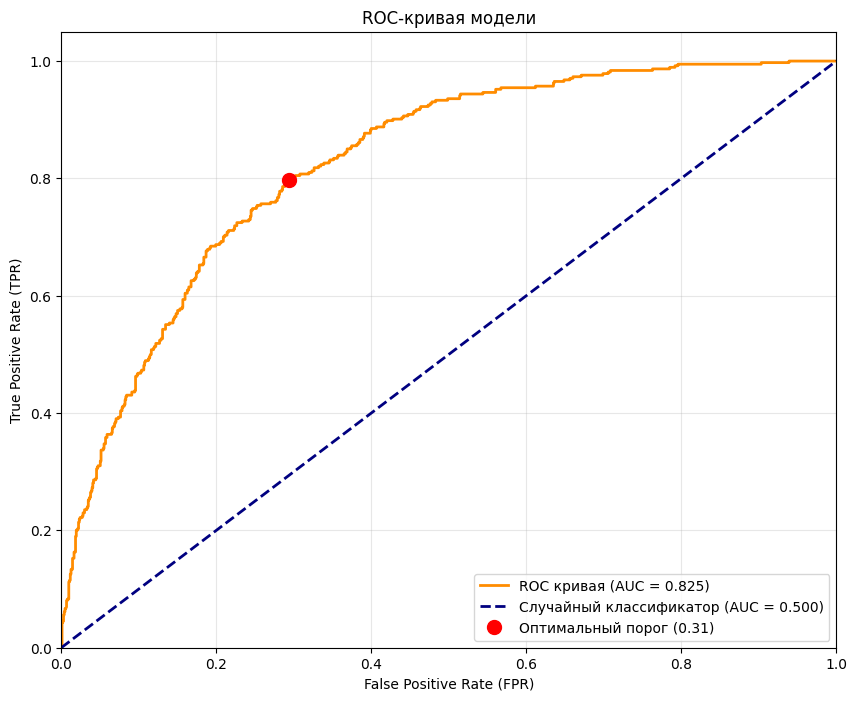

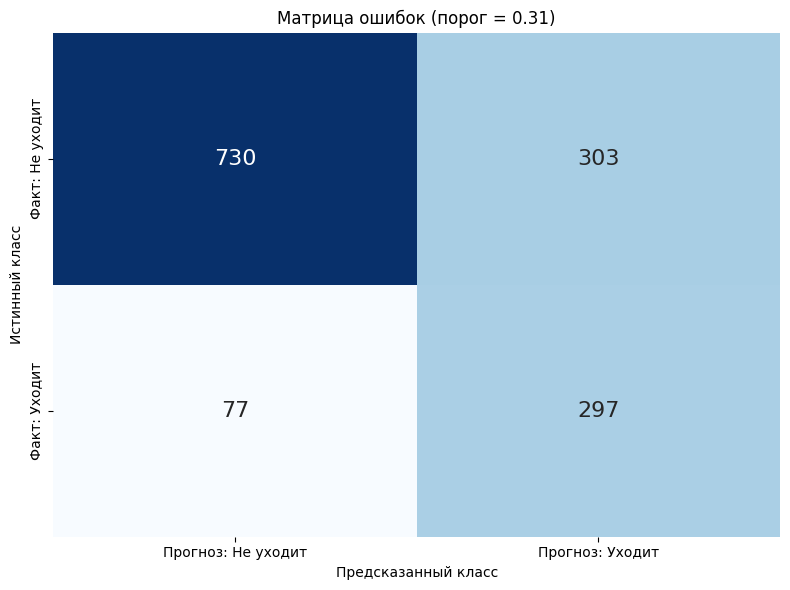


📊 Результаты ансамбля Forest + Boosting:
   ROC-AUC:  0.825
   F1-Score: 0.594
   Accuracy: 0.775
   PR-AUC: 0.618
   Precision: 0.572
   Recall: 0.618


In [7]:

ensemble1 = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(
            **forest_params,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
        ('gb', GradientBoostingClassifier(
            **grad_params,
            random_state=RANDOM_STATE
        ))
    ],
    voting='soft',  # Используем вероятности
    weights=[1, 1],  # Равные веса
    n_jobs=-1
)

print("Обучение ансамбля Forest + Boosting...")
ensemble1.fit(X_train, y_train)

# Предсказания
ensemble1_proba = ensemble1.predict_proba(X_test)[:, 1]
ensemble1_pred = ensemble1.predict(X_test)

rocPlot(y_test, ensemble1_proba, f"{type_data}_final_model_ensemble_forest_bosting")
erorrMatrixPlot(y_test, ensemble1_proba, f"{type_data}_final_model_ensemble_forest_bosting")

joblib.dump(ensemble1, f"../models/ensemble_forest_boosting_{type_data}.pkl") 

final_metrics = {
    'ROC-AUC': roc_auc_score(y_test, ensemble1_proba),
    'PR-AUC': average_precision_score(y_test, ensemble1_proba),
    'Accuracy': accuracy_score(y_test, ensemble1_pred),
    'F1-Score': f1_score(y_test, ensemble1_pred),
    'Precision': precision_score(y_test, ensemble1_pred),
    'Recall': recall_score(y_test, ensemble1_pred)
}

result_models.loc[len(result_models)] = {
    'model': 'ensemble forest+boosting',
    **final_metrics
}

print(f"\n📊 Результаты ансамбля Forest + Boosting:")
print(f"   ROC-AUC:  {final_metrics['ROC-AUC']:.3f}")
print(f"   F1-Score: {final_metrics['F1-Score']:.3f}")
print(f"   Accuracy: {final_metrics['Accuracy']:.3f}")
print(f"   PR-AUC: {final_metrics['PR-AUC']:.3f}")
print(f"   Precision: {final_metrics['Precision']:.3f}")
print(f"   Recall: {final_metrics['Recall']:.3f}")



🔧 Обучение ансамбля LogisticRegression + Forest (Stacking)...


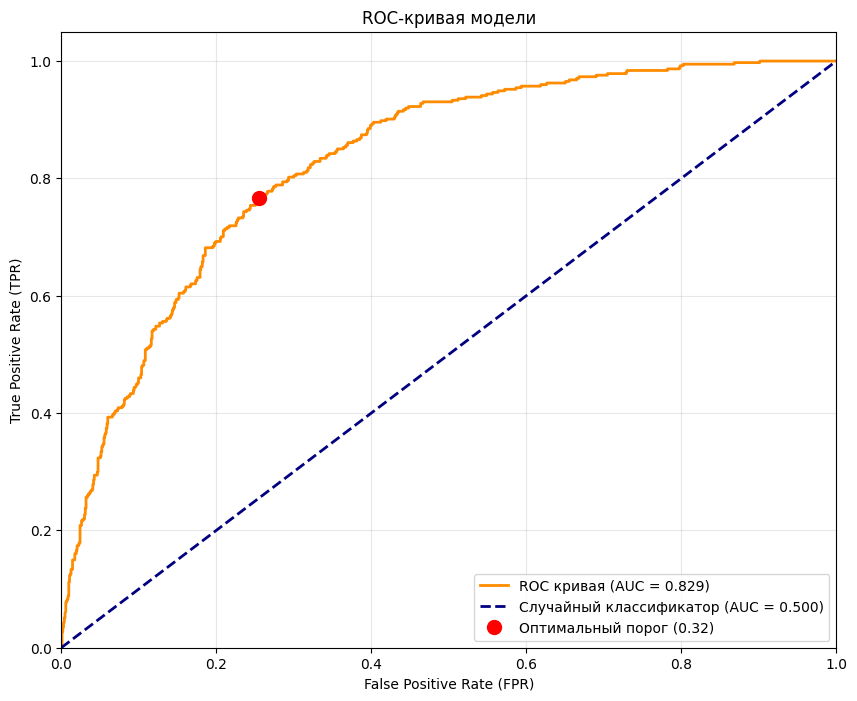

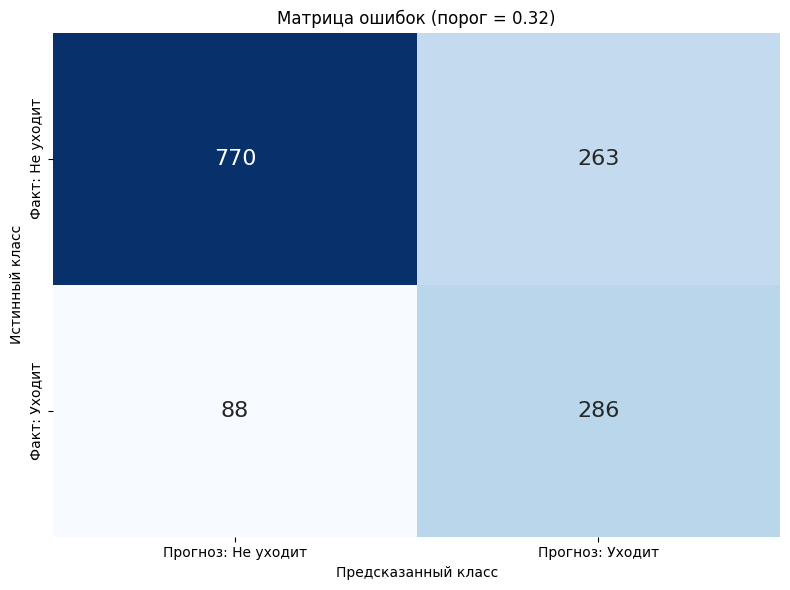


📊 Результаты ансамбля Forest + Boosting:
   ROC-AUC:  0.829
   F1-Score: 0.595
   Accuracy: 0.772
   PR-AUC: 0.618
   Precision: 0.563
   Recall: 0.631

📊 Результаты ансамбля Forest + Boosting:
   ROC-AUC:  0.829
   F1-Score: 0.595
   Accuracy: 0.772
   PR-AUC: 0.618
   Precision: 0.563
   Recall: 0.631


In [8]:
ensemble2 = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(
            max_iter=100,
            random_state=RANDOM_STATE
        )),
        ('rf', RandomForestClassifier(
            **forest_params,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ],
    final_estimator=LogisticRegression(max_iter=100, random_state=RANDOM_STATE),
    cv=3,  # 3-fold для обучения мета-модели
    passthrough=False,  # Используем только предсказания
    n_jobs=-1
)

print("🔧 Обучение ансамбля LogisticRegression + Forest (Stacking)...")
ensemble2.fit(X_train, y_train)

# Предсказания
ensemble2_proba = ensemble2.predict_proba(X_test)[:, 1]
ensemble2_pred = ensemble2.predict(X_test)

rocPlot(y_test, ensemble2_proba, f"{type_data}_final_model_ensemble_forest_logistic")
erorrMatrixPlot(y_test, ensemble2_proba, f"{type_data}_final_model_ensemble_forest_logistic")

joblib.dump(ensemble2, f"../models/ensemble_forest_logistic__{type_data}.pkl") 

print(f"\n📊 Результаты ансамбля Forest + Boosting:")
print(f"   ROC-AUC:  {roc_auc_score(y_test, ensemble2_proba):.3f}")
print(f"   F1-Score: {f1_score(y_test, ensemble2_pred):.3f}")
print(f"   Accuracy: {accuracy_score(y_test, ensemble2_pred):.3f}")
print(f"   PR-AUC: {average_precision_score(y_test, ensemble2_proba):.3f}")
print(f"   Precision: {precision_score(y_test, ensemble2_pred):.3f}")
print(f"   Recall: {recall_score(y_test, ensemble2_pred):.3f}")

final_metrics = {
    'ROC-AUC': roc_auc_score(y_test, ensemble2_proba),
    'PR-AUC': average_precision_score(y_test, ensemble2_proba),
    'Accuracy': accuracy_score(y_test, ensemble2_pred),
    'F1-Score': f1_score(y_test, ensemble2_pred),
    'Precision': precision_score(y_test, ensemble2_pred),
    'Recall': recall_score(y_test, ensemble2_pred)
}

result_models.loc[len(result_models)] = {
    'model': 'ensemble forest+logistic',
    **final_metrics
}

print(f"\n📊 Результаты ансамбля Forest + Boosting:")
print(f"   ROC-AUC:  {final_metrics['ROC-AUC']:.3f}")
print(f"   F1-Score: {final_metrics['F1-Score']:.3f}")
print(f"   Accuracy: {final_metrics['Accuracy']:.3f}")
print(f"   PR-AUC: {final_metrics['PR-AUC']:.3f}")
print(f"   Precision: {final_metrics['Precision']:.3f}")
print(f"   Recall: {final_metrics['Recall']:.3f}")

In [9]:

result_models.head()

,model,ROC-AUC,PR-AUC,Accuracy,F1-Score,Precision,Recall
0,final model,0.829743,0.620254,0.772566,0.598997,0.563679,0.639037
1,ensemble forest+boosting,0.825469,0.618041,0.775409,0.593830,0.571782,0.617647
2,ensemble forest+logistic,0.828731,0.618091,0.771855,0.595208,0.563246,0.631016


#### Анализ по метрикам (balanced data):


1. ROC-AUC (качество разделения классов)  
- final model: 0.8288 ✅ лучший
- ensemble forest+boosting: 0.8238  
- ensemble forest+logistic: 0.8236


2. PR-AUC (важен при дисбалансе классов)  
- final model: 0.6175 ✅ лучший  
- ensemble forest+boosting: 0.6110  
- ensemble forest+logistic: 0.6045


3. Accuracy (общая точность)  
- ensemble forest+boosting: 0.7761 ✅ лучший  
- ensemble forest+logistic: 0.7719  
- final model: 0.7647


4. F1-Score (баланс precision и recall)  
- final model: 0.6147 ✅ лучший  
- ensemble forest+logistic: 0.6109  
- ensemble forest+boosting: 0.6077


5. Precision (точность позитивных предсказаний)  
- ensemble forest+boosting: 0.5688 ✅ лучший  
- ensemble forest+logistic: 0.5588  
- final model: 0.5443


6. Recall (полнота - сколько реальных позитивных нашли)  
- final model: 0.7059 ✅ лучший  
- ensemble forest+logistic: 0.6738   
- ensemble forest+boosting: 0.6524


#### Общая оценка:  
- final model показывает лучшее качество классификации (ROC-AUC) и лучше выявляет реальный отток (Recall)
- ensemble forest+boosting более точен в предсказаниях (Precision) и имеет лучшую общую точность

### Анализ по метрикам (unbalanced data):  

1. ROC-AUC (качество разделения классов):  
- ensemble forest+logistic: 0.8419 ✅ лучший
- ensemble forest+boosting: 0.8400
- final model: 0.8392


2. PR-AUC (важен при дисбалансе классов):  
- ensemble forest+logistic: 0.6591 ✅ лучший
- ensemble forest+boosting: 0.6522
- final model: 0.6512


3. Accuracy (общая точность):  
- ensemble forest+logistic: 0.7989 ✅ лучший
- ensemble forest+boosting: 0.7967
- final model: 0.7939


4. F1-Score (баланс precision и recall):  
- ensemble forest+logistic: 0.5732 ✅ лучший
- final model: 0.5672
- ensemble forest+boosting: 0.5600


5. Precision (точность позитивных предсказаний):  
- ensemble forest+boosting: 0.6594 ✅ лучший
- ensemble forest+logistic: 0.6574
- final model: 0.6419


6. Recall (полнота - сколько реальных позитивных нашли):  
- final model: 0.5080 ✅ лучший
- ensemble forest+logistic: 0.5080 ✅ лучший
- ensemble forest+boosting: 0.4866


ensemble forest+logistic является явным лидером - лучший в большинстве метрик

#### Анализ по метрикам (средне сбалансированные данные):


1. ROC-AUC (качество разделения классов):  
- final model: 0.8297 ✅ лучший  
- ensemble forest+logistic: 0.8287  
- ensemble forest+boosting: 0.8255


2. PR-AUC (важен при дисбалансе классов):  
- final model: 0.6203 ✅ лучший  
- ensemble forest+logistic: 0.6181  
- ensemble forest+boosting: 0.6180


3. Accuracy (общая точность):  
- ensemble forest+boosting: 0.7754 ✅ лучший  
- final model: 0.7726  
- ensemble forest+logistic: 0.7719


4. F1-Score (баланс precision и recall):  
- final model: 0.5990 ✅ лучший  
- ensemble forest+logistic: 0.5952  
- ensemble forest+boosting: 0.5938


5. Precision (точность позитивных предсказаний):  
- ensemble forest+boosting: 0.5718 ✅ лучший  
- final model: 0.5637  
- ensemble forest+logistic: 0.5632


6. Recall (полнота - сколько реальных позитивных нашли):  
- final model: 0.6390 ✅ лучший  
- ensemble forest+logistic: 0.6310  
- ensemble forest+boosting: 0.6176


final model: лучший компромисс F1=0.599, Recall=0.639, Precision=0.564

## Итог

### Таблица сравнения лучших моделей по типам данных
| Тип данных              | Лучшая модель          | ROC-AUC | PR-AUC | Accuracy | F1-Score | Precision | Recall | Сильные стороны                             |
|-------------------------|------------------------|---------|--------|----------|----------|-----------|--------|---------------------------------------------|
| Несбалансированные      | ensemble forest+logistic | 0.8419  | 0.6591 | 0.7989   | 0.5732   | 0.6574    | 0.5080 | Лучшее общее качество, высокая точность     |
| Полностью сбалансированные | final model            | 0.8288  | 0.6175 | 0.7647   | 0.6147   | 0.5443    | 0.7059 | Максимальное выявление оттока              |
| Среднесбалансированные  | final model            | 0.8297  | 0.6203 | 0.7726   | 0.5990   | 0.5637    | 0.6390 | Оптимальный баланс метрик                  |


Выбор модели будет зависеть от потребностей бизнеса и выявленных сильных сторон каждой из моделей

Для дальнейшего анализа будет выбрана модель с оптимальным балансом метрик т.е. **модель обученная на среднесбалансированных данных**